In [1]:
import numpy as np
import gym
import seaborn as sns
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning
import matplotlib.pyplot as plt
import time
from pprint import pprint
import pickle
from matplotlib.colors import ListedColormap

In [2]:
env = gym.make('FrozenLake-v0')
env.reset()
done = False

In [3]:
def get_score(env, policy_arr, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        state_idx = env.reset()
        steps=0
        while True:
            action_idx = policy_arr[state_idx]
            state_idx, reward, done, info = env.step(action_idx)
            steps+=1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
                
    avg_steps = round(np.mean(steps_list), 0)
    success_rate = 1 - misses/episodes  
    
    return avg_steps, success_rate

In [4]:
def plot_policy(env, policy_arrs, iterations):
    
    if len(policy_arrs) == 1:
        rows = 1
        cols = 2
    else:
        rows = len(policy_arrs) // 5
        rows = rows + 1 if len(policy_arrs) % 5 else rows
        cols = 5
        
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3,rows*5)) 
    for iteration, ax, policy_arr in zip(iterations, axes.ravel(), policy_arrs):
        
        nbr_states = env.nS
        nbr_rows = int(np.sqrt(nbr_states))
        nbr_cols = int(np.sqrt(nbr_states))

        action_dict = {0:'<', 1:'v', 2:'>', 3:'^'}
        state_labels = np.vectorize(action_dict.get)(policy_arr)
        state_labels = np.char.array(state_labels)

        desc = env.unwrapped.desc.ravel().astype(str)
        desc = np.char.array(desc)
        desc = np.core.defchararray.add('|', desc)

        state_action_labels = np.core.defchararray.add(state_labels, desc)
        state_labels = state_labels.reshape(nbr_rows, nbr_cols)

        sns.heatmap(policy_arr.reshape(nbr_rows, nbr_cols), 
                    linewidth=0.5, 
                    annot=state_action_labels.reshape(nbr_rows, nbr_cols),
                    cmap=ListedColormap(['gray']),
                    fmt = '',
                    cbar=False,
                    ax=ax)
        
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        ax.title.set_text(f'policy at iteration {iteration}')
        
    fig.tight_layout()
    plt.suptitle('Policies against iterations')
    plt.subplots_adjust(top=0.9)
    plt.show()

### Set up matrices for pymdptoolbox

In [5]:
transitions = np.zeros((env.nA, env.nS, env.nS))
reward_arr = np.zeros((env.nA, env.nS, env.nS))
for orig_state_idx, orig_state_details in env.P.items():
    for action_idx, action_details in orig_state_details.items():
        for idx, ele in enumerate(action_details):
            next_state_idx = ele[1]
            reward = ele[2]
            done = ele[3]
            prob = ele[0]
#             if done:
#                 prob = 0
#             else:
#                 prob = ele[0]
            transitions[action_idx, orig_state_idx, next_state_idx] += prob
            reward_arr[action_idx, orig_state_idx, next_state_idx] = reward

### Value iteration

In [26]:
val_iter_perf_dict = {}
gamma_list = [0.3, 0.5, 0.7, 0.9, 0.99]
epsilon_list = [0.001, 0.0001, 0.00001]
best_score = 0
for gamma in gamma_list:
    for epsilon in epsilon_list:
        experiment_id = f'gamma={gamma}_epsilon={epsilon}'
        value_iteration_mdp = mdptoolbox.mdp.ValueIteration(transitions, reward_arr, gamma = gamma, epsilon = epsilon)
        value_iteration_mdp.run()
        state_val_arr = np.asarray(value_iteration_mdp.V)
        policy_arr = np.asarray(value_iteration_mdp.policy)
        iterations_taken = value_iteration_mdp.iter
        time_taken = value_iteration_mdp.time
        avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
#             plot_policy(env, policy_arr)
        summary = experiment_id + f', Value iteration took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(100*success_rate,2)}% success rate'
        print(summary)
        
        experiment_dict = {}
        experiment_dict['state_val_arr'] = state_val_arr
        experiment_dict['policy_arr'] = policy_arr
        experiment_dict['iterations_taken'] = iterations_taken
        experiment_dict['time_taken'] = time_taken
        experiment_dict['avg_steps'] = avg_steps
        experiment_dict['score'] = success_rate
        experiment_dict['p_cumulative'] = value_iteration_mdp.p_cumulative
        experiment_dict['error_mean'] = value_iteration_mdp.error_mean
        experiment_dict['run_stats'] = value_iteration_mdp.run_stats
        val_iter_perf_dict[experiment_id] = experiment_dict
        
        with open('frozenlake_val_iter_output.txt', 'a') as f:
            f.write(summary)

        with open('frozenlake_val_iter_dict.pickle', 'wb') as handle:
            pickle.dump(val_iter_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        if success_rate > best_score:
            best_score = success_rate
            best_params = experiment_id
        
print(f'best params are {best_params}')

gamma=0.3_epsilon=0.001, Value iteration took 4 iterations and 0.00031 seconds, achieved 22.72% success rate
gamma=0.3_epsilon=0.0001, Value iteration took 6 iterations and 0.00046 seconds, achieved 20.62% success rate
gamma=0.3_epsilon=1e-05, Value iteration took 8 iterations and 0.00054 seconds, achieved 45.12% success rate
gamma=0.5_epsilon=0.001, Value iteration took 7 iterations and 0.00047 seconds, achieved 44.21% success rate
gamma=0.5_epsilon=0.0001, Value iteration took 10 iterations and 0.00074 seconds, achieved 45.02% success rate
gamma=0.5_epsilon=1e-05, Value iteration took 13 iterations and 0.00081 seconds, achieved 44.74% success rate
gamma=0.7_epsilon=0.001, Value iteration took 12 iterations and 0.0008 seconds, achieved 44.16% success rate
gamma=0.7_epsilon=0.0001, Value iteration took 18 iterations and 0.00123 seconds, achieved 43.9% success rate
gamma=0.7_epsilon=1e-05, Value iteration took 24 iterations and 0.00143 seconds, achieved 44.69% success rate
gamma=0.9_eps

Value iteration took 39.0 avg steps, achieved 73.7% success rate and 0.01315 seconds


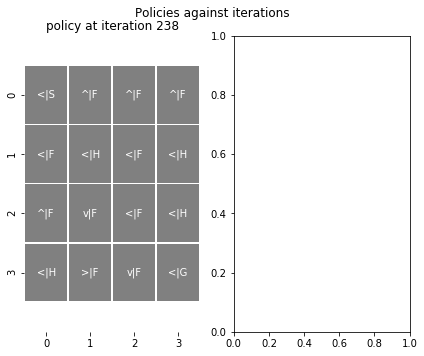

In [27]:
state_val_arr = val_iter_perf_dict[best_params]['state_val_arr']
policy_arr = val_iter_perf_dict[best_params]['policy_arr']
iterations_taken = val_iter_perf_dict[best_params]['iterations_taken']
time_taken = val_iter_perf_dict[best_params]['time_taken']
avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
print(f'Value iteration took {avg_steps} avg steps, achieved {round(100*success_rate,2)}% success rate and {round(time_taken, 5)} seconds')
plot_policy(env, [policy_arr], [iterations_taken])

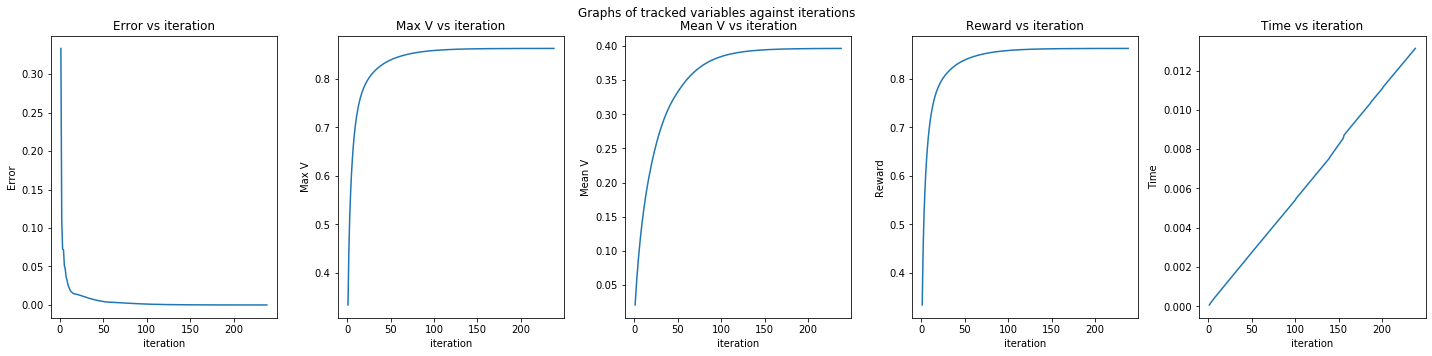

In [28]:
stats_list = val_iter_perf_dict[best_params]['run_stats']
graphs = ['Error', 'Max V', 'Mean V', 'Reward', 'Time']
fig, axes = plt.subplots(1,5, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    iterations_list = [stats['Iteration'] for stats in stats_list]
    variable_list = [stats[graph] for stats in stats_list]
    ax.plot(iterations_list, variable_list, label=graph)
    ax.title.set_text(f'{graph} vs iteration')
    ax.set_xlabel('iteration')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Graphs of tracked variables against iterations')
plt.subplots_adjust(top=0.9)
plt.show()

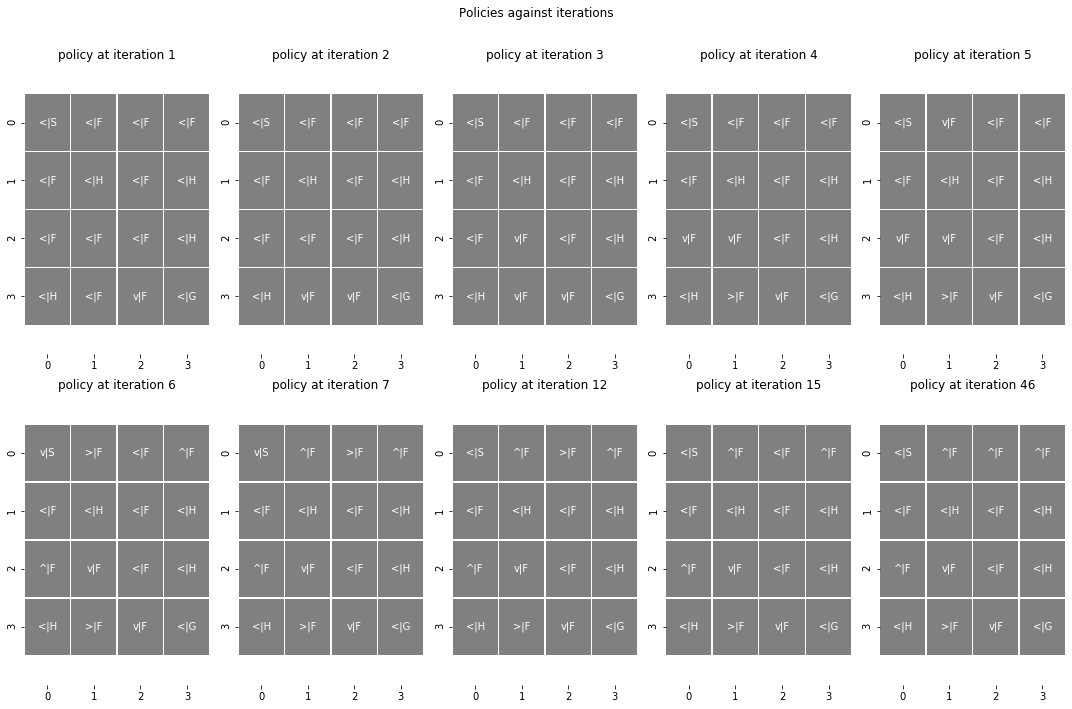

In [9]:
p_cumulative = val_iter_perf_dict[best_params]['p_cumulative']
length = len(p_cumulative)
every_n = 1 if length // 10 == 0 else length // 10
iterations = []
policy_arrs = []
for idx, p_cum in enumerate(p_cumulative):
    if idx % every_n > 0:
        continue
    iterations.append(p_cum[0])
    policy_arrs.append(p_cum[1])
plot_policy(env, policy_arrs, iterations)

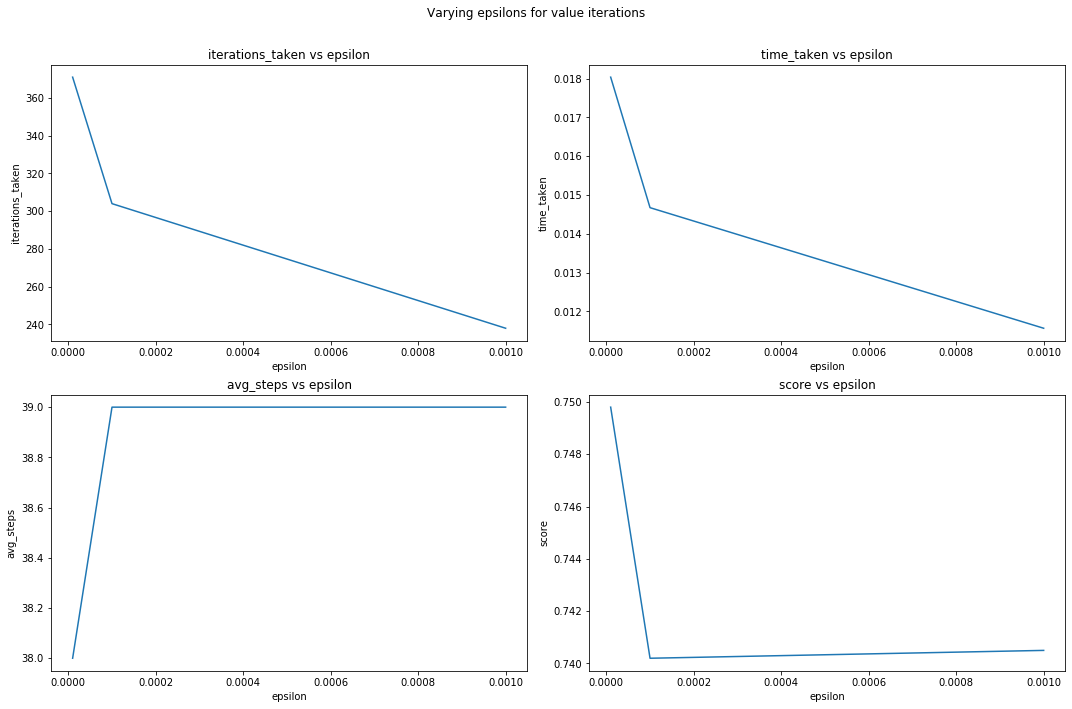

In [10]:
graphs = ['iterations_taken', 'time_taken', 'avg_steps', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in [0.99]:
    for epsilon in epsilon_list:
        experiment_id = f'gamma={gamma}_epsilon={epsilon}'
        for graph in graphs:
            variables_dict[graph].append(val_iter_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(2,2, figsize=(15,10))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(epsilon_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs epsilon')
    ax.set_xlabel('epsilon')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying epsilons for value iterations')
plt.subplots_adjust(top=0.9)
plt.show()

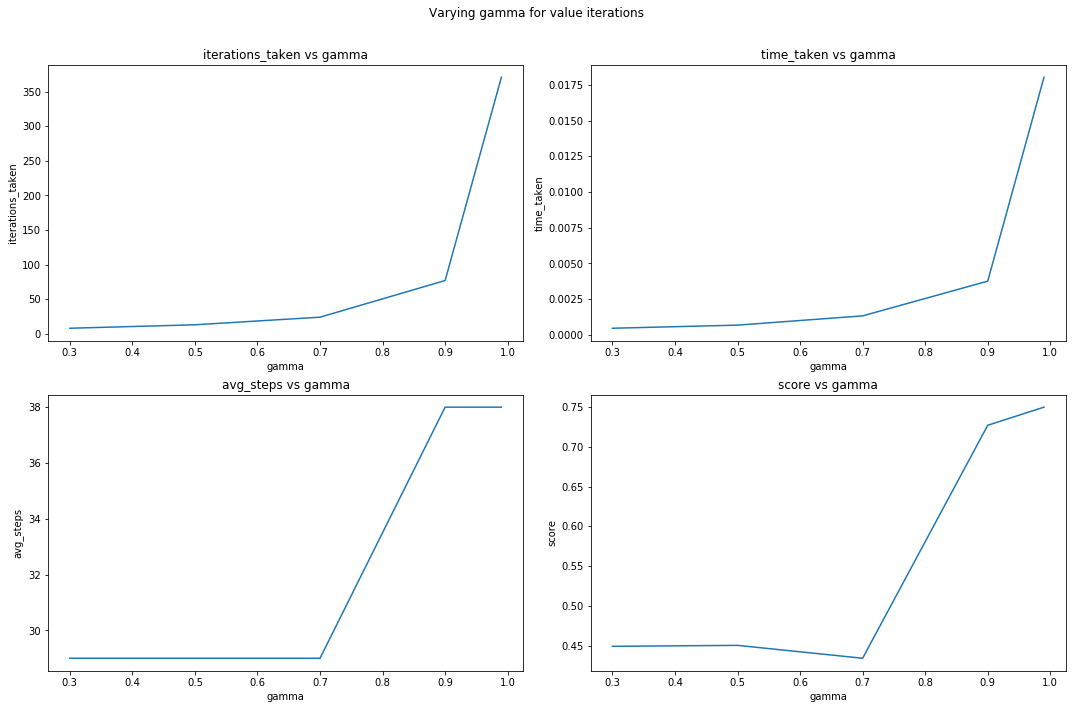

In [11]:
graphs = ['iterations_taken', 'time_taken', 'avg_steps', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in gamma_list:
    for epsilon in [0.00001]:
        experiment_id = f'gamma={gamma}_epsilon={epsilon}'
        for graph in graphs:
            variables_dict[graph].append(val_iter_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(2,2, figsize=(15,10))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(gamma_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs gamma')
    ax.set_xlabel('gamma')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying gamma for value iterations')
plt.subplots_adjust(top=0.9)
plt.show()

### Policy iteration

In [12]:
policy_iter_perf_dict = {}
best_score = 0
gamma_list = [0.3, 0.5, 0.7, 0.9, 0.99]
for gamma in gamma_list:
    experiment_id = f'gamma={gamma}'

    policy_iteration_mdp = mdptoolbox.mdp.PolicyIteration(transitions, reward_arr, gamma = gamma)
    policy_iteration_mdp.run()
    state_val_arr = np.asarray(policy_iteration_mdp.V)
    policy_arr = np.asarray(policy_iteration_mdp.policy)
    iterations_taken = policy_iteration_mdp.iter
    time_taken = policy_iteration_mdp.time
    avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
#     plot_policy(env, policy_arr)
    summary = experiment_id + f', Policy iteration took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(100*success_rate,2)}% success rate'
    print(summary)

    experiment_dict = {}
    experiment_dict['state_val_arr'] = state_val_arr
    experiment_dict['policy_arr'] = policy_arr
    experiment_dict['iterations_taken'] = iterations_taken
    experiment_dict['time_taken'] = time_taken
    experiment_dict['avg_steps'] = avg_steps
    experiment_dict['score'] = success_rate
    experiment_dict['p_cumulative'] = policy_iteration_mdp.p_cumulative
    experiment_dict['error_mean'] = policy_iteration_mdp.error_mean
    experiment_dict['run_stats'] = policy_iteration_mdp.run_stats
    policy_iter_perf_dict[experiment_id] = experiment_dict
    
    with open('frozenlake_policy_iter_output.txt', 'a') as f:
        f.write(summary)

    with open('frozenlake_policy_iter_dict.pickle', 'wb') as handle:
        pickle.dump(policy_iter_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    if success_rate > best_score:
        best_score = success_rate
        best_params = experiment_id
        
print(f'best params are {best_params}')

gamma=0.3, Policy iteration took 4 iterations and 0.00273 seconds, achieved 45.32% success rate
gamma=0.5, Policy iteration took 4 iterations and 0.0017 seconds, achieved 44.32% success rate
gamma=0.7, Policy iteration took 4 iterations and 0.00173 seconds, achieved 44.81% success rate
gamma=0.9, Policy iteration took 5 iterations and 0.00204 seconds, achieved 73.29% success rate
gamma=0.99, Policy iteration took 7 iterations and 0.00291 seconds, achieved 75.22% success rate
best params are gamma=0.99


Policy iteration took 39.0 avg steps, achieved 73.58% success rate and 0.00291 seconds


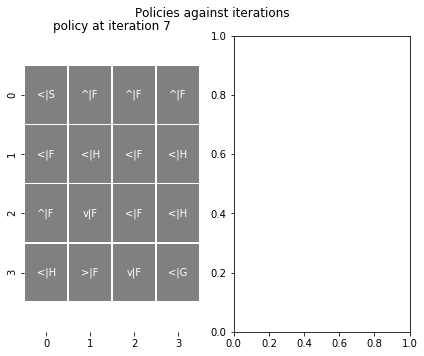

In [13]:
state_val_arr = policy_iter_perf_dict[best_params]['state_val_arr']
policy_arr = policy_iter_perf_dict[best_params]['policy_arr']
iterations_taken = policy_iter_perf_dict[best_params]['iterations_taken']
time_taken = policy_iter_perf_dict[best_params]['time_taken']
avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
print(f'Policy iteration took {avg_steps} avg steps, achieved {round(100*success_rate,2)}% success rate and {round(time_taken, 5)} seconds')
plot_policy(env, [policy_arr], [iterations_taken])

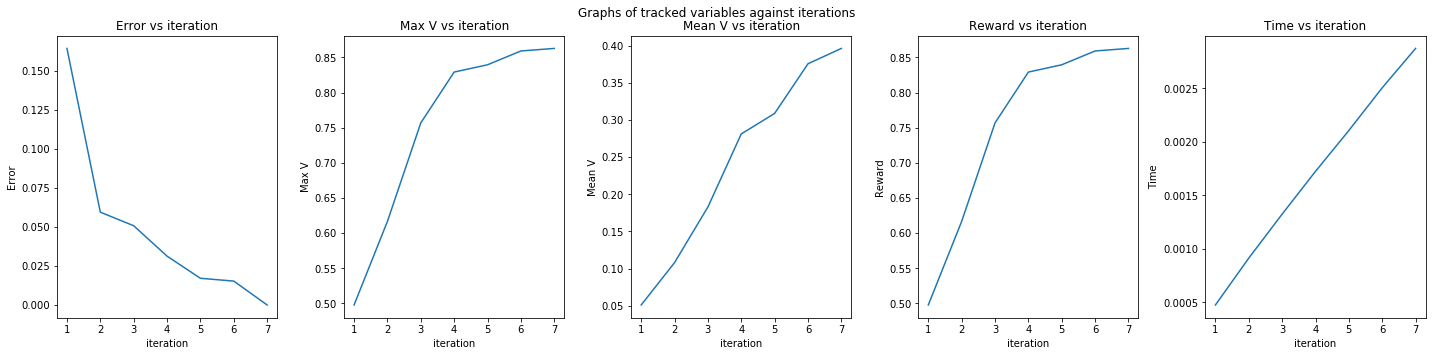

In [14]:
stats_list = policy_iter_perf_dict[best_params]['run_stats']
graphs = ['Error', 'Max V', 'Mean V', 'Reward', 'Time']
fig, axes = plt.subplots(1,5, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    iterations_list = [stats['Iteration'] for stats in stats_list]
    variable_list = [stats[graph] for stats in stats_list]
    ax.plot(iterations_list, variable_list, label=graph)
    ax.title.set_text(f'{graph} vs iteration')
    ax.set_xlabel('iteration')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Graphs of tracked variables against iterations')
plt.subplots_adjust(top=0.9)
plt.show()

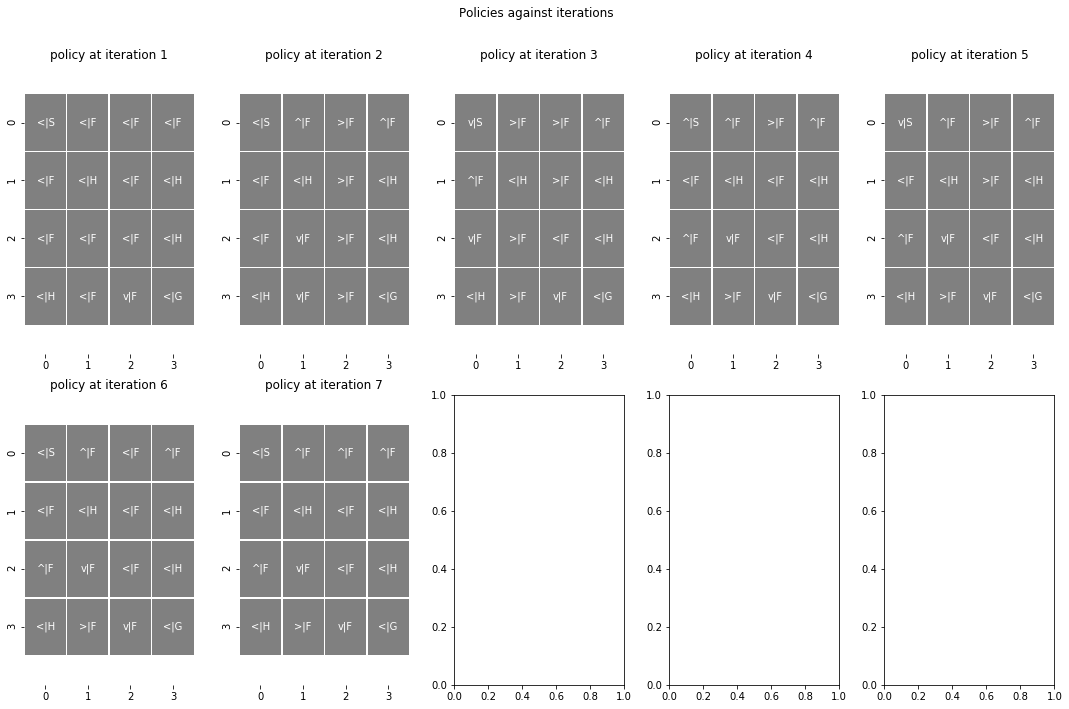

In [15]:
p_cumulative = policy_iter_perf_dict[best_params]['p_cumulative']
iterations = [p_cum[0] for p_cum in p_cumulative]
policy_arrs = [p_cum[1] for p_cum in p_cumulative]
plot_policy(env, policy_arrs, iterations)

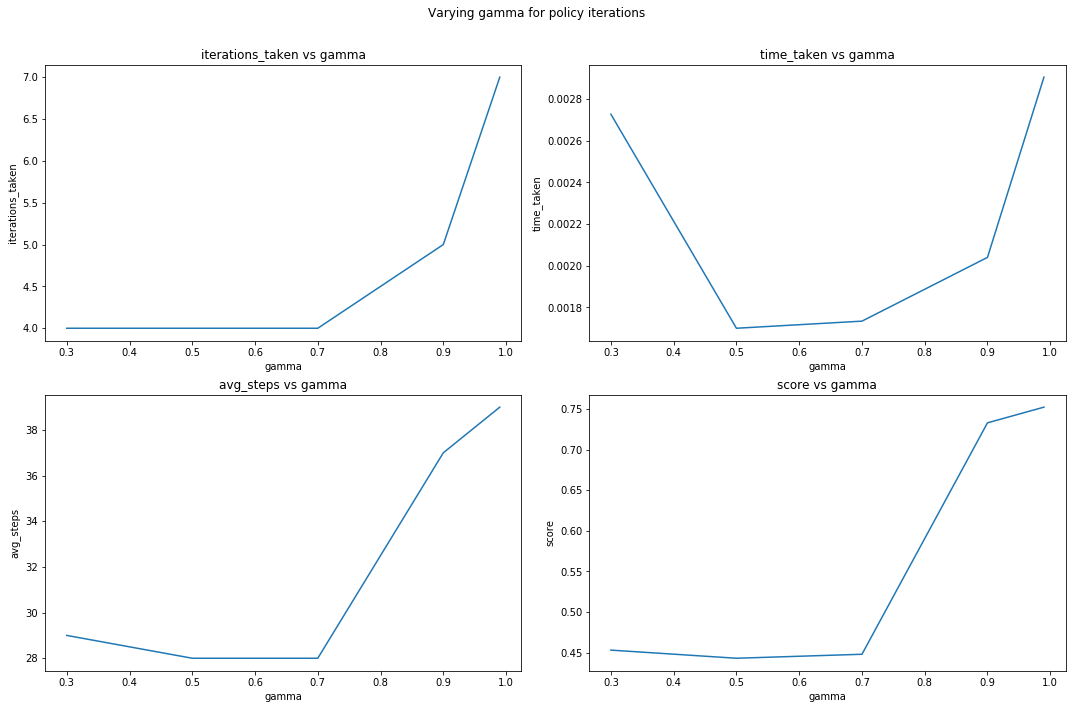

In [16]:
graphs = ['iterations_taken', 'time_taken', 'avg_steps', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in gamma_list:
    experiment_id = f'gamma={gamma}'
    for graph in graphs:
        variables_dict[graph].append(policy_iter_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(2,2, figsize=(15,10))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(gamma_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs gamma')
    ax.set_xlabel('gamma')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying gamma for policy iterations')
plt.subplots_adjust(top=0.9)
plt.show()

### Q-learning

In [17]:
qlearning_perf_dict = {}
best_score = 0
gamma_list = [0.5, 0.7, 0.9, 0.99]
n_iter_list = [100000, 1000000, 10000000, 100000000]
for gamma in gamma_list:
    for n_iter in n_iter_list:
        experiment_id = f'gamma={gamma}_n_iter={n_iter}'
        qlearning_mdp = mdptoolbox.mdp.QLearning(transitions, reward_arr, gamma = gamma, n_iter = n_iter)
        qlearning_mdp.run()
        state_val_arr = np.asarray(qlearning_mdp.V)
        policy_arr = np.asarray(qlearning_mdp.policy)
        time_taken = qlearning_mdp.time
        avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
    #     plot_policy(env, policy_arr)
        summary = experiment_id + f', Qlearning took {n_iter} iterations and {round(time_taken, 5)} seconds, achieved {round(100*success_rate,2)}% success rate'
        print(summary)

        experiment_dict = {}
        experiment_dict['state_val_arr'] = state_val_arr
        experiment_dict['policy_arr'] = policy_arr
        experiment_dict['iterations_taken'] = iterations_taken
        experiment_dict['time_taken'] = time_taken
        experiment_dict['avg_steps'] = avg_steps
        experiment_dict['score'] = success_rate
        experiment_dict['p_cumulative'] = qlearning_mdp.p_cumulative
        experiment_dict['error_mean'] = qlearning_mdp.error_mean
        experiment_dict['run_stats'] = qlearning_mdp.run_stats
        qlearning_perf_dict[experiment_id] = experiment_dict

        with open('frozenlake_qlearning_output.txt', 'a') as f:
            f.write(summary)

        with open('frozenlake_qlearning_dict.pickle', 'wb') as handle:
            pickle.dump(qlearning_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        if success_rate > best_score:
            best_score = success_rate
            best_params = experiment_id

print(f'best params are {best_params}') #gamma=0.9_n_iter=100000000

gamma=0.5_n_iter=100000, Qlearning took 100000 iterations and 3.77487 seconds, achieved 17.84% success rate
gamma=0.5_n_iter=1000000, Qlearning took 1000000 iterations and 35.38584 seconds, achieved 6.79% success rate
gamma=0.5_n_iter=10000000, Qlearning took 10000000 iterations and 365.12652 seconds, achieved 7.86% success rate
gamma=0.5_n_iter=100000000, Qlearning took 100000000 iterations and 3596.60206 seconds, achieved 44.17% success rate
gamma=0.7_n_iter=100000, Qlearning took 100000 iterations and 4.33545 seconds, achieved 10.43% success rate
gamma=0.7_n_iter=1000000, Qlearning took 1000000 iterations and 36.78736 seconds, achieved 4.8% success rate
gamma=0.7_n_iter=10000000, Qlearning took 10000000 iterations and 367.27811 seconds, achieved 24.35% success rate
gamma=0.7_n_iter=100000000, Qlearning took 100000000 iterations and 3597.37451 seconds, achieved 50.69% success rate
gamma=0.9_n_iter=100000, Qlearning took 100000 iterations and 4.34577 seconds, achieved 5.19% success ra

Qlearning took 38.0 avg steps, achieved 73.91% success rate and 3609.65396 seconds


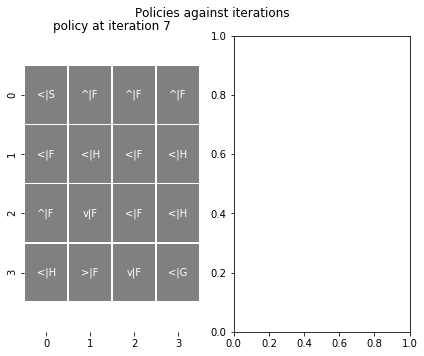

In [18]:
state_val_arr = qlearning_perf_dict[best_params]['state_val_arr']
policy_arr = qlearning_perf_dict[best_params]['policy_arr']
iterations_taken = qlearning_perf_dict[best_params]['iterations_taken']
time_taken = qlearning_perf_dict[best_params]['time_taken']
avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
print(f'Qlearning took {avg_steps} avg steps, achieved {round(100*success_rate,2)}% success rate and {round(time_taken, 5)} seconds')
plot_policy(env, [policy_arr], [iterations_taken])

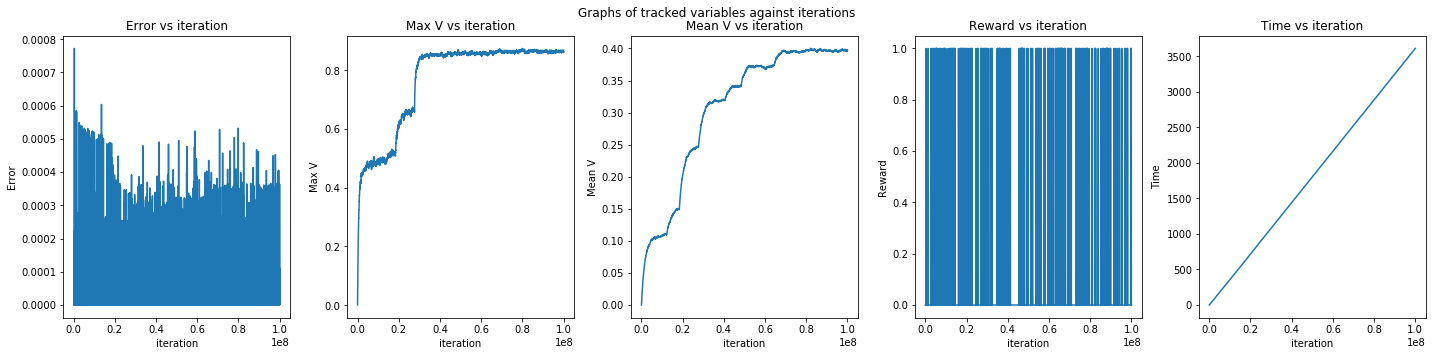

In [19]:
stats_list = qlearning_perf_dict[best_params]['run_stats']
graphs = ['Error', 'Max V', 'Mean V', 'Reward', 'Time']
fig, axes = plt.subplots(1,5, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    iterations_list = [stats['Iteration'] for stats in stats_list]
    variable_list = [stats[graph] for stats in stats_list]
    ax.plot(iterations_list, variable_list, label=graph)
    ax.title.set_text(f'{graph} vs iteration')
    ax.set_xlabel('iteration')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Graphs of tracked variables against iterations')
plt.subplots_adjust(top=0.9)
plt.show()

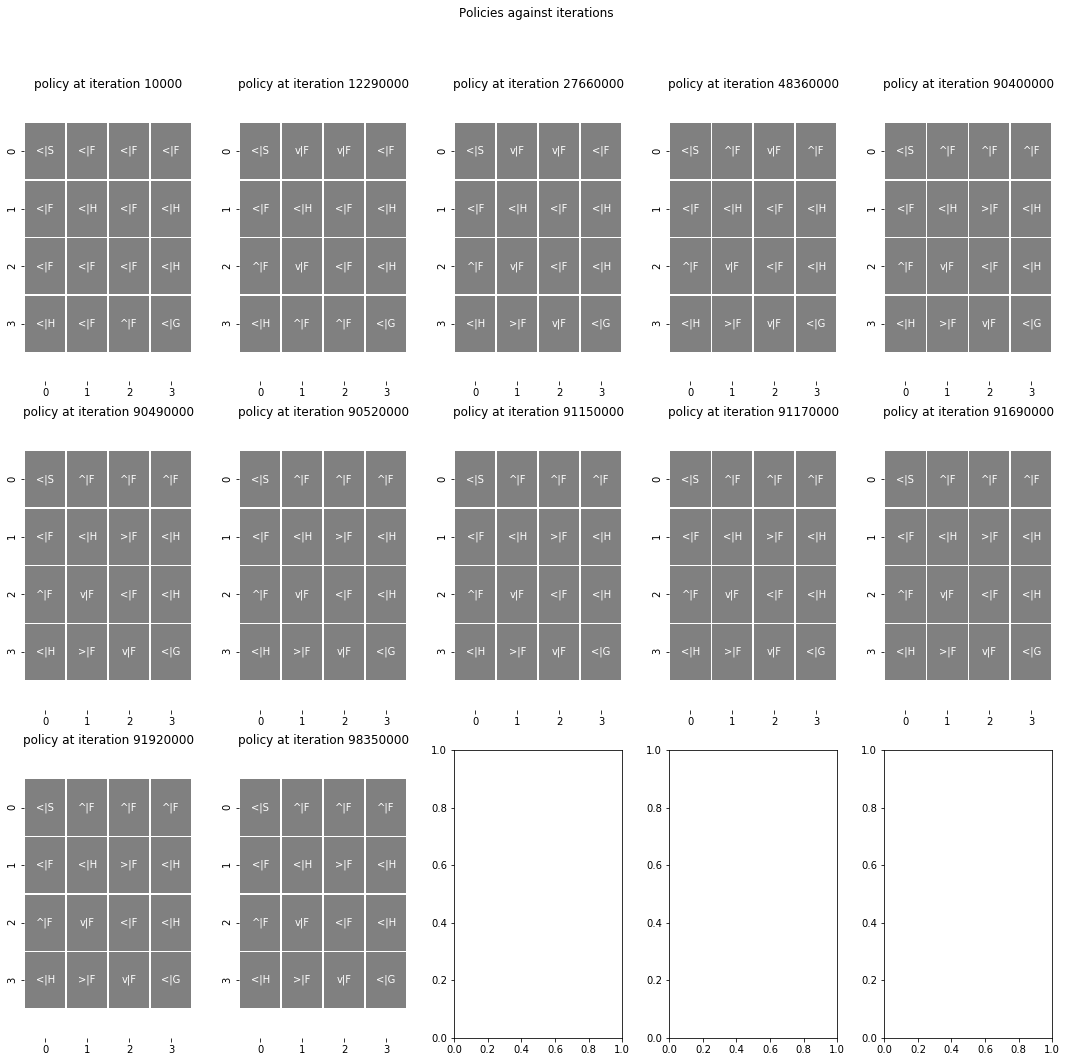

In [24]:
p_cumulative = qlearning_perf_dict[best_params]['p_cumulative']
length = len(p_cumulative)
every_n = 1 if length // 10 == 0 else length // 10
iterations = []
policy_arrs = []
for idx, p_cum in enumerate(p_cumulative):
    if idx % every_n > 0:
        continue
    iterations.append(p_cum[0])
    policy_arrs.append(p_cum[1])
plot_policy(env, policy_arrs, iterations)

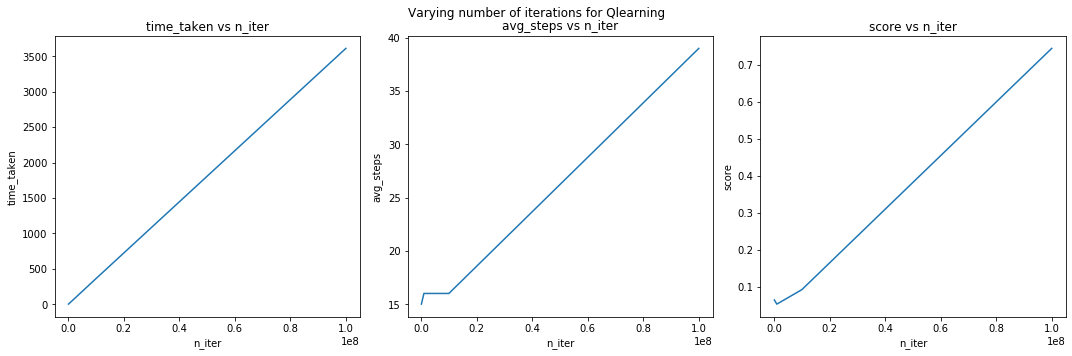

In [39]:
graphs = ['time_taken', 'avg_steps', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in [0.99]:
    for n_iter in n_iter_list:
        experiment_id = f'gamma={gamma}_n_iter={n_iter}'
        for graph in graphs:
            variables_dict[graph].append(qlearning_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(n_iter_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs n_iter')
    ax.set_xlabel('n_iter')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying number of iterations for Qlearning')
plt.subplots_adjust(top=0.9)
plt.show()

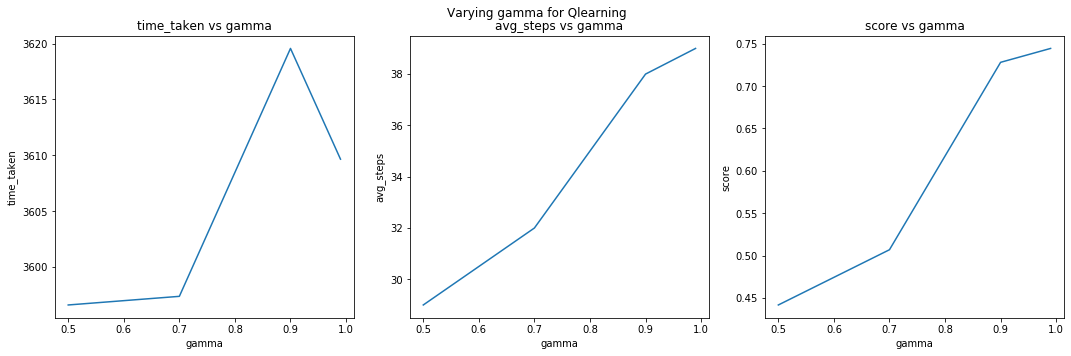

In [42]:
graphs = ['time_taken', 'avg_steps', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in gamma_list:
    for n_iter in [100000000]:
        experiment_id = f'gamma={gamma}_n_iter={n_iter}'
        for graph in graphs:
            variables_dict[graph].append(qlearning_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(gamma_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs gamma')
    ax.set_xlabel('gamma')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying gamma for Qlearning')
plt.subplots_adjust(top=0.9)
plt.show()

### Comparing 3 algo

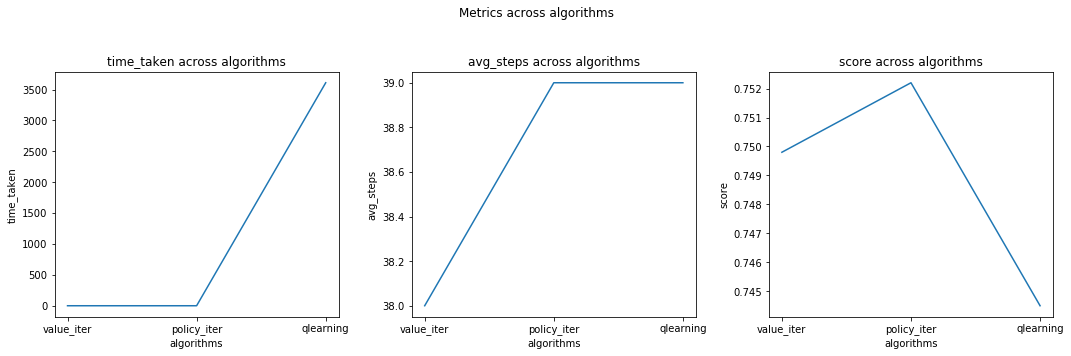

In [23]:
with open('frozenlake_val_iter_dict.pickle', 'rb') as handle:
    val_iter_perf_dict = pickle.load(handle)
    
with open('frozenlake_policy_iter_dict.pickle', 'rb') as handle:
    policy_iter_perf_dict = pickle.load(handle)
    
with open('frozenlake_qlearning_dict.pickle', 'rb') as handle:
    qlearning_perf_dict = pickle.load(handle)

fig, axes = plt.subplots(1,3, figsize=(15,5))
graphs = ['time_taken', 'avg_steps', 'score']
algos = ['value_iter', 'policy_iter', 'qlearning']
for ax, graph in zip(axes.ravel(), graphs):
    variable_list = []
    for perf_dict in [val_iter_perf_dict, policy_iter_perf_dict, qlearning_perf_dict]:
        best_score = 0
        for exp_id, metrics in perf_dict.items():
            if metrics['score'] >= best_score:
                best_params = exp_id
                best_score = metrics['score']
        best_var = perf_dict[best_params][graph]
        variable_list.append(best_var)
        
    ax.plot(algos, variable_list, label=graph)
    ax.title.set_text(f'{graph} across algorithms')
    ax.set_xlabel('algorithms')
    ax.set_ylabel(graph)
        
    
fig.tight_layout()
plt.suptitle('Metrics across algorithms')
plt.subplots_adjust(top=0.8)
plt.show()